**Initialization**

In [1]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

**Task 1: Data set**

The dataset comes directly in a two split dataset for test and train data. The test dataset has 10000 images, the train dataset is coming with 50000 images. The images in the data have a shape of 32 x 32 x 3 and do not need to be resized in any way.

In [2]:
# INPUT PIPELINE

batch_size = 32
prefetch_size = 16

# Step 1: Load the data itself.
(train_input, train_labels), (test_input, test_labels) = tf.keras.datasets.cifar10.load_data()


# Step 2: Create datasets from input images for test and train data standardize it and change the dtype of the images to tf.float32, because needed for the model.
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_input)
train_dataset_images = train_dataset_images.map(lambda img: tf.image.per_image_standardization(img))
train_dataset_images = train_dataset_images.map(lambda img: tf.dtypes.cast(img, tf.float32))

test_dataset_images = tf.data.Dataset.from_tensor_slices(test_input)
test_dataset_images = test_dataset_images.map(lambda img: tf.image.per_image_standardization(img))
test_dataset_images = test_dataset_images.map(lambda img: tf.dtypes.cast(img, tf.float32))


# Step 3: Create datasets for targets using the labels and one-hot encoded targets for 10 possible labels for test and train data 
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset_targets = train_dataset_targets.map(lambda tar: tf.one_hot(tar, 10))

test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda tar: tf.one_hot(tar, 10))


# Step 4: Zip dataset images and targets together for train and test data
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = batch_size)
train_dataset = train_dataset.prefetch(prefetch_size)

test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size = batch_size)
test_dataset = test_dataset.prefetch(prefetch_size)   



170500096/170498071 [==============================] - 6s 0us/step


In [3]:
# Description: The function return the label as a spelling context and not a number anymore. Just useful for diplaying the images with its labels.
#              @parameters: label
#              @returns: spelling_label

def get_spelling_context(label):
  if(label == 0):
    spelling_label = "Airplane"
  
  if(label == 1):
    spelling_label = "Automobile"
  
  if(label == 2):
    spelling_label = "Bird"
  
  if(label == 3):
    spelling_label = "Cat"
  
  if(label == 4):
    spelling_label = "Deer"
  
  if(label == 5):
    spelling_label = "Dog"
  
  if(label == 6):
    spelling_label = "Frog"
  
  if(label == 7):
    spelling_label = "Horse"

  if(label == 8):
    spelling_label = "Ship"

  if(label == 9):
    spelling_label = "Truck"
  
  return spelling_label

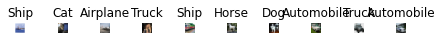

In [4]:
# This part visualizes 10 random pictures with its labels from the train dataset.

data_index = np.random.randint(0, high = len(train_input), size = 10)

fig, ax = plt.subplots(1,10)
img_number = 0
for i in range(max(data_index)+1):
  if(np.any(data_index == i)):
    img = train_input[i]
    lbl = get_spelling_context(train_labels[i])

    ax[img_number].imshow(img)
    ax[img_number].set_title(lbl)
    ax[img_number].axis("off")
        
    img_number += 1

fig.tight_layout()
plt.show()

**Task 2: Model**

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# Description: The class Model describes a convolutional neural network with a feature extractor and 
#              a classifier.
#              @class variables: -
#              @object variables: conv_1, max_pool_1, conv_2, max_pool_2, conv_3, max_pool_3, 
#                                 global_pool, output
#              @functions: call
class Model(Model): 
  
    def __init__(self):
        super(Model, self).__init__()

        # Feature extractor
        self.conv_1 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, activation=tf.keras.activations.relu, input_shape=(32, 32, 3))
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, activation=tf.keras.activations.tanh)
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        self.conv_3 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, activation=tf.keras.activations.relu)
        self.max_pool_3 = tf.keras.layers.MaxPool2D()

        # Classifier
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)


    # Description: This function conducts one forward-step of the model. 
    #              A python decorator (@tf.function) is used to bundle multiple computations into one computational graph.
    #              @parameters: (input) x
    #              @returns: (prediction) x
    @tf.function
    def call(self, x):
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)

        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

**Task 3: Training**

In [6]:
# Description: This function trains an object of the class Model. It conducts a forward-step and the backpropagation 
#              throughout the network. Additionally, it determines the average training loss and accuracy.
#              @parameters: model, training_data, loss_fn, optimizer
#              @returns: training_loss, training_accuracy
def training_step(model, training_data, loss_fn, optimizer):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input)
      current_training_loss = loss_fn(target, prediction)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))   
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of an object of the class Model.
#              @parameters: model, test_data, loss_fn
#              @returns: test_loss, test_accuracy
def test(model, test_data, loss_fn):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


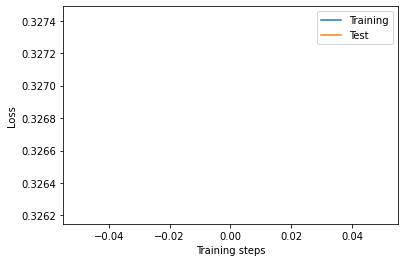

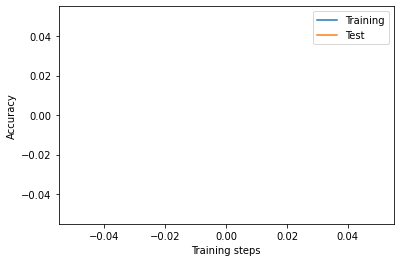

Epoch 1


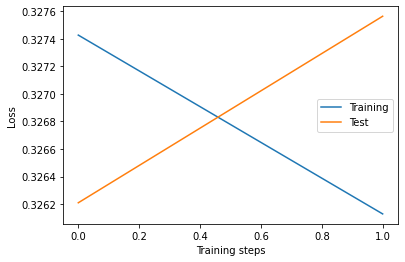

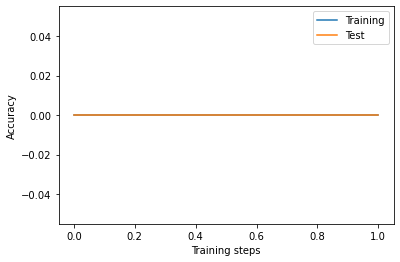

Epoch 2


In [ ]:
# Description: This part creates an object of the class Model called model and executes the training and testing of the model in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
tf.keras.backend.clear_session()

model = Model()
n_epochs = 20
learning_rate = 0.00008
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad=True)    # Adam = Adaptive Moment Estimation

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))


    training_loss, training_accuracy = training_step(model, train_dataset, loss_fn, optimizer)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Visualization while training to check how the network is doing
    plt.figure()
    line1, = plt.plot(training_losses)
    line2, = plt.plot(test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1, line2),("Training", "Test"))
    plt.show()

    plt.figure()
    line1, = plt.plot(training_accuracies)
    line2, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.legend((line1, line2),("Training", "Test"))
    plt.show()

**Task 4: Visualization**



In [ ]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

for n, i in enumerate(test_accuracies):
   print(str(n) +": " + str(i))